In [1]:
#need to use a GPU to make the training part faster
import torch

#if there's a GPU available, use it
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))

#otherwise use the CPU
else:
  print('No GPU available, using the CPU instead.')
  device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
#install transformers
!pip install transformers

In [3]:
#cd into the correct directory to get the data file
import pandas as pd
import json

from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/CAIS++/F23_Curriculum/Winter Project

Mounted at /content/drive/
/content/drive/My Drive/CAIS++/F23_Curriculum/Winter Project


In [4]:
#parses the data
data_list = []

with open('/content/drive/My Drive/CAIS++/F23_Curriculum/Winter Project/Sarcasm_Headlines_Dataset.json') as f:
  for line in f:
    data_list.append(json.loads(line))

#converts json to a dataframe
df = pd.json_normalize(data_list)

print(df)

                                            article_link  \
0      https://www.huffingtonpost.com/entry/versace-b...   
1      https://www.huffingtonpost.com/entry/roseanne-...   
2      https://local.theonion.com/mom-starting-to-fea...   
3      https://politics.theonion.com/boehner-just-wan...   
4      https://www.huffingtonpost.com/entry/jk-rowlin...   
...                                                  ...   
26704  https://www.huffingtonpost.com/entry/american-...   
26705  https://www.huffingtonpost.com/entry/americas-...   
26706  https://www.huffingtonpost.com/entry/reparatio...   
26707  https://www.huffingtonpost.com/entry/israeli-b...   
26708  https://www.huffingtonpost.com/entry/gourmet-g...   

                                                headline  is_sarcastic  
0      former versace store clerk sues over secret 'b...             0  
1      the 'roseanne' revival catches up to our thorn...             0  
2      mom starting to fear son's web series closest ...    

In [5]:
#shows 10 random rows
df.sample(10)

,article_link,headline,is_sarcastic
19968,https://www.theonion.com/wildfire-somehow-rage...,wildfire somehow rages back into control,1
19612,https://www.huffingtonpost.com/entry/processin...,processing the facts: what will ferguson's leg...,0
1125,https://www.theonion.com/cuba-to-buy-car-18195...,cuba to buy car,1
20364,https://www.theonion.com/historical-archives-a...,historical archives: a puzzle for the mind,1
5708,https://www.huffingtonpost.com/entry/trumpleth...,trumplethinskin: a president's day fable,0
15545,https://www.theonion.com/arianna-huffington-ha...,arianna huffington has webcam implanted in for...,1
25823,https://www.huffingtonpost.com/entry/china-pla...,chinese military plane makes first public land...,0
22008,https://www.huffingtonpost.com/entry/if-state-...,if state takeover of new orleans schools worke...,0
975,https://www.huffingtonpost.com/entry/the-drama...,"the drama desks, all the way, m&m's and more",0
21252,https://www.theonion.com/well-doesnt-area-busi...,"well, doesn't area businessman look dapper for...",1


In [9]:
#shows 5 samples where the headline isn't sarcastic
df.loc[df.is_sarcastic == 0].sample(5)[['headline', 'is_sarcastic']]

,headline,is_sarcastic
21796,democratic election sweep may complicate gop p...,0
22627,the valentine's day cards of your wildest lesb...,0
24959,o'reilly indeed embellishing war reporting exp...,0
4396,scott walker still won't say whether obama is ...,0
15341,kfc urged to stop routine use of antibiotics o...,0


In [10]:
#get list of headlines and if they're sarcastic or not
headlines = df.headline.values
sarcasm = df.is_sarcastic.values

In [11]:
#import and load Bert Tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
#prints original headline
print('Original: ', headlines[0])

#prints headline split into tokens
print('Tokenized: ', tokenizer.tokenize(headlines[0]))

#prints headline mapped to token ids
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(headlines[0])))

Original:  former versace store clerk sues over secret 'black code' for minority shoppers
Tokenized:  ['former', 'versa', '##ce', 'store', 'clerk', 'sue', '##s', 'over', 'secret', "'", 'black', 'code', "'", 'for', 'minority', 'shop', '##pers']
Token IDs:  [2280, 18601, 3401, 3573, 7805, 9790, 2015, 2058, 3595, 1005, 2304, 3642, 1005, 2005, 7162, 4497, 7347]


In [13]:
max_len = 0

#for every headline
for head in headlines:
  #tokenize it and add the special CLS and SEP tokens
  input_ids = tokenizer.encode(head, add_special_tokens=True)

  #update max headline length
  max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  66


In [14]:
#go through and tokenize each headline and map the tokens to their word IDs
input_ids = []
attention_masks = []

#for every headline
for head in headlines:
  #tokenize, add CLS and SEP tokens, map tokens to word IDs
  #pad the headlines, create attention masks to ignore padded tokens
  #returns pytorch tensors
  encoded_dict = tokenizer.encode_plus(
                  head,
                  add_special_tokens = True,
                  max_length = 72,
                  pad_to_max_length = True,
                  return_attention_mask = True,
                  return_tensors = 'pt',
                  )
  #add encoded headline into input_ids list
  input_ids.append(encoded_dict['input_ids'])
  #add attention masks encoded headline into attention_masks list
  attention_masks.append(encoded_dict['attention_mask'])

#converts lists to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
sarcasm = torch.tensor(sarcasm)

#print the sentence and its encoded version
print('Original: ', headlines[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  former versace store clerk sues over secret 'black code' for minority shoppers
Token IDs: tensor([  101,  2280, 18601,  3401,  3573,  7805,  9790,  2015,  2058,  3595,
         1005,  2304,  3642,  1005,  2005,  7162,  4497,  7347,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])


In [15]:
#train & validation split
from torch.utils.data import TensorDataset, random_split

#combines all 3 lists into 1 tensor dataset
dataset = TensorDataset(input_ids, attention_masks, sarcasm)

#calculates # of samples to include in each set
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

#splits the dataset randomly
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#prints amounts for each
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

24,038 training samples
2,671 validation samples


In [16]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#recommended batch size for training
batch_size = 32

#creates dataloaders for training set
train_dataloader = DataLoader(
            train_dataset,  #training samples.
            sampler = RandomSampler(train_dataset), #selects batches randomly
            batch_size = batch_size #trains using this batch size
        )

#creates dataloaders for validation set
validation_dataloader = DataLoader(
            val_dataset, #validation samples.
            sampler = SequentialSampler(val_dataset), #selects batches sequentially, order doesn't matter for val
            batch_size = batch_size #evaluates with this batch size
        )

In [17]:
#training classification model
from transformers import BertForSequenceClassification, AdamW, BertConfig

#load and use pretrained BERT model w/ linear classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", #use BERT model on lowercase text
    num_labels = 2, #number of output labels--2 for binary classification
    output_attentions = False, #whether the model returns attentions weights
    output_hidden_states = False, #whether the model returns all hidden-states.
)

#tells pytorch to run this model on the GPU
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [18]:
#define optimizer (used to adjust parameters)
#recommended learning rate & epsilon
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
from transformers import get_linear_schedule_with_warmup

#recommended epochs
epochs = 4

#total # of training steps: # of batches * epochs
#how many times model's parameters are updated during training process
total_steps = len(train_dataloader) * epochs

#creates learning rate schedulelr
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps= total_steps)

In [20]:
#helper function for accuracy

import numpy as np

#calculates predictions vs whether it's sarcastic or not (labels)
def helper_accuracy(preds, sarcasm):
  pred_flat = np.argmax(preds, axis=1).flatten()
  sarcasm_flat = sarcasm.flatten()
  return np.sum(pred_flat == sarcasm_flat) / len(sarcasm_flat)

In [21]:
#helper function for elapsing time

import time
import datetime

def helper_time(elapsed):
  elapsed_rounded = int(round((elapsed)))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
#training

import random
import numpy as np

seed_val = 42

#sets random seeds for all those libraries
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#list to store number of train/val loss, accuracy, etc.
training_stats = []

#measure total training time for whole run
total_t0 = time.time()

#for every epoch
for epoch_i in range(0, epochs):
    #perform one full pass over training set
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    #measure how long the training epoch takes
    t0 = time.time()

    #reset the total loss for this epoch
    total_train_loss = 0

    #put model into training mode
    model.train()

    #for each batch of training data
    for step, batch in enumerate(train_dataloader):

        #update every 40 batches
        if step % 40 == 0 and not step == 0:
            #calculate elapsed time in minutes.
            elapsed = helper_time(time.time() - t0)

            #report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 0 the gradients
        model.zero_grad()

        # Forward pass, calculate logit predictions.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = helper_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += helper_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = helper_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(helper_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    752.    Elapsed: 0:00:17.
  Batch    80  of    752.    Elapsed: 0:00:33.
  Batch   120  of    752.    Elapsed: 0:00:48.
  Batch   160  of    752.    Elapsed: 0:01:03.
  Batch   200  of    752.    Elapsed: 0:01:18.
  Batch   240  of    752.    Elapsed: 0:01:34.
  Batch   280  of    752.    Elapsed: 0:01:49.
  Batch   320  of    752.    Elapsed: 0:02:05.
  Batch   360  of    752.    Elapsed: 0:02:20.
  Batch   400  of    752.    Elapsed: 0:02:35.
  Batch   440  of    752.    Elapsed: 0:02:50.
  Batch   480  of    752.    Elapsed: 0:03:06.
  Batch   520  of    752.    Elapsed: 0:03:21.
  Batch   560  of    752.    Elapsed: 0:03:36.
  Batch   600  of    752.    Elapsed: 0:03:51.
  Batch   640  of    752.    Elapsed: 0:04:07.
  Batch   680  of    752.    Elapsed: 0:04:22.
  Batch   720  of    752.    Elapsed: 0:04:37.

  Average training loss: 0.28
  Training epcoh took: 0:04:49

Running Validation...
  Accuracy: 0.93
  Validat

In [23]:
import pandas as pd

#display floats with two decimal places
pd.set_option('display.precision', 2)

#create dataframe from our training statistics
df_stats = pd.DataFrame(data=training_stats)

#use 'epoch' as row index
df_stats = df_stats.set_index('epoch')

#display table
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.28,0.18,0.93,0:04:49,0:00:11
2,0.12,0.19,0.93,0:04:46,0:00:11
3,0.06,0.31,0.93,0:04:46,0:00:11
4,0.03,0.33,0.93,0:04:45,0:00:11


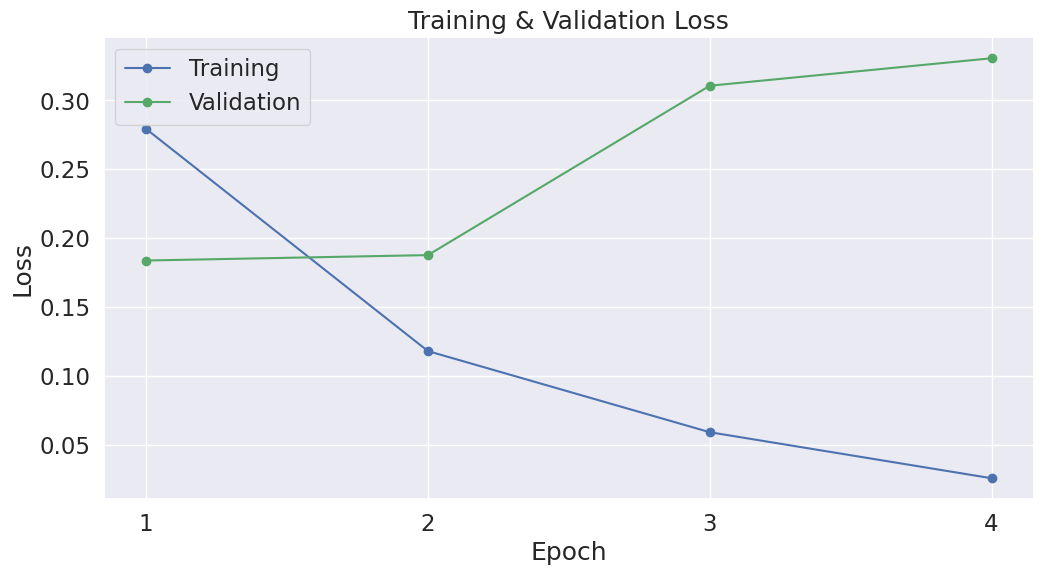

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

#use plot styling from seaborn
sns.set(style='darkgrid')

#set plot and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

#plot learning curve of train and val loss
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

#label the plot
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

#display plot
plt.show()

In [25]:
#preparing our test data set

import pandas as pd

#create sentence and label lists
headlines = df.headline.values
sarcasm = df.is_sarcastic.values

#go through and tokenize each headline and map the tokens to their word IDs
input_ids = []
attention_masks = []

#for every headline
for head in headlines:
    #tokenize, add CLS and SEP tokens, map tokens to word IDs
    #pad the headlines, create attention masks to ignore padded tokens
    #returns pytorch tensors
    encoded_dict = tokenizer.encode_plus(
                        head,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    #add encoded headline into input_ids list
    input_ids.append(encoded_dict['input_ids'])
    #add attention masks encoded headline into attention_masks list
    attention_masks.append(encoded_dict['attention_mask'])

#converts lists to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
sarcasm = torch.tensor(sarcasm)

#set the batch size
batch_size = 32

#create the DataLoader -- predictions are processed in order of input data
prediction_data = TensorDataset(input_ids, attention_masks, sarcasm)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [26]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 26,709 test sentences...
    DONE.


In [27]:
#prints how many samples are sarcastic (is_sarcastic = 1)
print('Positive samples: %d of %d (%.2f%%)' % (df.is_sarcastic.sum(), len(df.is_sarcastic), (df.is_sarcastic.sum() / len(df.is_sarcastic) * 100.0)))

Positive samples: 11724 of 26709 (43.90%)


In [28]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

#evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

#for each input batch
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # into a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [29]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)
#MCC tells us difference between our predictions and actual outcomes

Total MCC: 0.981


In [43]:
if mcc >= 0.7:
  interpretation = 'Strong agreement'
elif 0.4 <= mcc < 0.7:
  interpretation = 'Moderate agreement'
else:
  interpretation = 'Weak agreement'
print('Interpretation:', interpretation)

Interpretation: Strong agreement


Additional stuff I did to look at the data

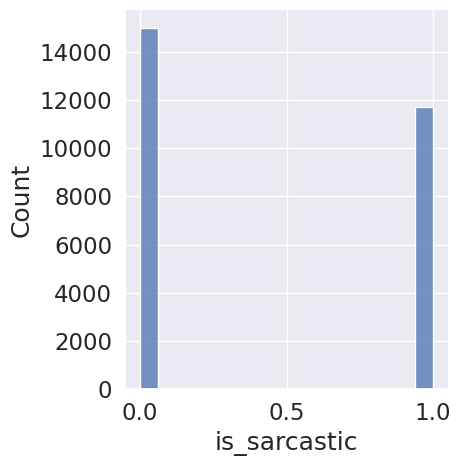

In [31]:
sns.displot(df['is_sarcastic'])

Here and below it seems like there's more 0's than 1's for sarcastic headlines, which makes sense why the Positive samples is less than half (43.90%) when is_sarcastic = 1.

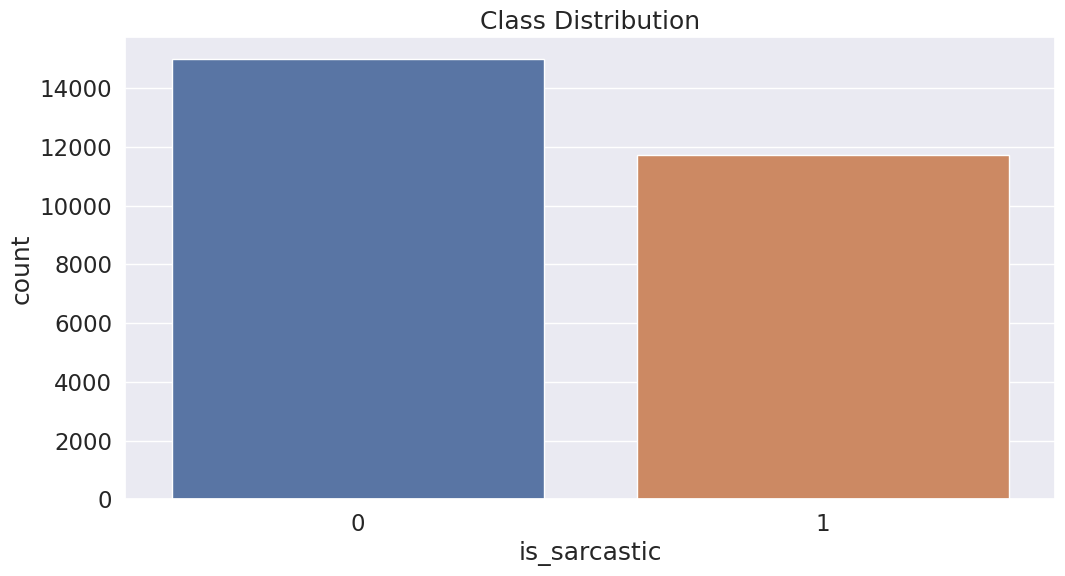

Class Distribution: 
0    14985
1    11724
Name: is_sarcastic, dtype: int64


In [38]:
class_distribution = df['is_sarcastic'].value_counts()
sns.countplot(x='is_sarcastic', data=df)
plt.title('Class Distribution')
plt.show()

print("Class Distribution: ")
print(class_distribution)

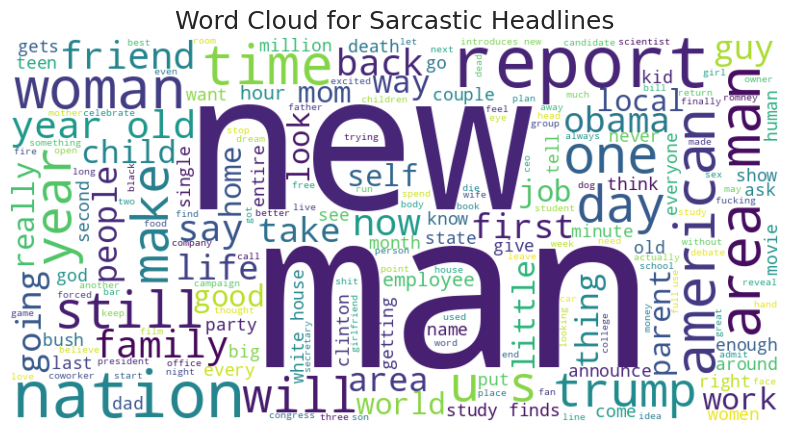

In [39]:
from wordcloud import WordCloud

# generate word cloud for sarcastic headlines
sarcastic_text = ' '.join(df[df['is_sarcastic'] == 1]['headline'])
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Sarcastic Headlines')
plt.show()

Word cloud to show the words that often showed up in the sarcastic headlines

In [44]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(flat_true_labels, flat_predictions)
print('Confusion matrix:')
print(confusion)

Confusion matrix:
[[14885   100]
 [  149 11575]]


Prints a matrix of the true negative, false positive, false negative, and true positive. This means there were 14,885/14,985 true negatives and 100 false positives. There were 11,575/11,724 true positives and 149 false negatives. Precision for non-sarcastic would be 14,885/14,985 = 0.99 and for sarcastic it would be 11,575/11,724 = 0.99. These numbers add up with what's shown below.

In [45]:
from sklearn.metrics import classification_report
report = classification_report(flat_true_labels, flat_predictions)
print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14985
           1       0.99      0.99      0.99     11724

    accuracy                           0.99     26709
   macro avg       0.99      0.99      0.99     26709
weighted avg       0.99      0.99      0.99     26709



Precision for non-sarcastic and sarcastic is both 99% so almost all of the predicted sarcastic/non-sarcastic examples are correct. Recall, or the true positive rate, is also 99% for both. F1 score is the harmonic mean of precision and recall and is 99% for both, which makes sense considering the precision and recall was 0.99 for both too. Support adds up with the numbers I showed in the countplot and displot. Accuracy is 99% which is really good.

In [46]:
from sklearn.metrics import roc_auc_score, roc_curve
auc_score = roc_auc_score(flat_true_labels, flat_predictions)
fpr, tpr, _ = roc_curve(flat_true_labels, flat_predictions)
print('AUC Score:', auc_score)

AUC Score: 0.9903088434732925


This means the model has a good abililty to distinguish between positive and negative examples as it is close to 1.

In [47]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(flat_true_labels, flat_predictions)
pr_auc = auc(recall, precision)
print('Precision-Recall AUC:', pr_auc)

Precision-Recall AUC: 0.9921521801817786


Indicates a great balance between precision and recall since it's close to 1.